## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

#     def forward(self, x, label):
    def forward(self, x):
#         out = self.input(torch.cat((x, label), -1))
        out = self.input(x)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
        out = self.hidden2(out)
        out = F.relu(out)
        
        out = self.hidden3(out)
        out = F.relu(out)
        
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

#         self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.input = nn.Linear(latent_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.2)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(0.5)
        
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z, label):
    def forward(self, z):
#         out = self.input(torch.cat((z, label), -1))
        out = self.input(z)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
        out = self.hidden2(out)
        out = F.relu(out)
        
        out = self.hidden3(out)
#         out = self.bn3(out)
        out = F.relu(out)
# #         out = self.dropout3(out)
        
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
print(len(bos.feature_names))
df["Price"] = bos.target

data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data["Price"] = df.Price

13


In [4]:
from sklearn import preprocessing

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

# Standardize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [5]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [6]:
""" Hyperparameters """
N_EPOCHS = 1200    # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 5

In [7]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [8]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-7)

In [10]:
train_loss_avg = []
test_losses = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
#         mu_z, std_z = encoder(x, y)
        mu_z, std_z = encoder(x)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
#         mu_x, std_x = decoder(z_samples, y)
        mu_x, std_x = decoder(z_samples)
        eps = torch.randn_like(std_x)

#         x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
    
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    
    mu_z, std_z = encoder(X_test)
    
    eps = torch.randn_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)

    mu_x, std_x = decoder(z_samples)
    eps = torch.randn_like(std_x)

    loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, X_test)

    test_losses.append(loss.item())
    
    print("Epoch [%d / %d] average loss: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))
    print("Epoch [%d / %d] test loss: %f" % (ep+1, N_EPOCHS, test_losses[-1]))

Epoch [1 / 1200] average loss: 20.504909
Epoch [1 / 1200] test loss: 20.733250
Epoch [2 / 1200] average loss: 20.435806
Epoch [2 / 1200] test loss: 20.579389
Epoch [3 / 1200] average loss: 20.336591
Epoch [3 / 1200] test loss: 20.478219
Epoch [4 / 1200] average loss: 20.236476
Epoch [4 / 1200] test loss: 20.444267
Epoch [5 / 1200] average loss: 20.136865
Epoch [5 / 1200] test loss: 20.436546
Epoch [6 / 1200] average loss: 20.134236
Epoch [6 / 1200] test loss: 20.224508
Epoch [7 / 1200] average loss: 20.026102
Epoch [7 / 1200] test loss: 20.213287
Epoch [8 / 1200] average loss: 19.974789
Epoch [8 / 1200] test loss: 20.098471
Epoch [9 / 1200] average loss: 19.837545
Epoch [9 / 1200] test loss: 19.995087
Epoch [10 / 1200] average loss: 19.794818
Epoch [10 / 1200] test loss: 20.058976
Epoch [11 / 1200] average loss: 19.749650
Epoch [11 / 1200] test loss: 20.010559
Epoch [12 / 1200] average loss: 19.716069
Epoch [12 / 1200] test loss: 19.927643
Epoch [13 / 1200] average loss: 19.642155
Epoc

Epoch [108 / 1200] average loss: 18.475734
Epoch [108 / 1200] test loss: 18.730769
Epoch [109 / 1200] average loss: 18.462119
Epoch [109 / 1200] test loss: 18.724929
Epoch [110 / 1200] average loss: 18.471055
Epoch [110 / 1200] test loss: 18.757389
Epoch [111 / 1200] average loss: 18.466255
Epoch [111 / 1200] test loss: 18.726676
Epoch [112 / 1200] average loss: 18.466730
Epoch [112 / 1200] test loss: 18.757738
Epoch [113 / 1200] average loss: 18.449794
Epoch [113 / 1200] test loss: 18.751813
Epoch [114 / 1200] average loss: 18.460094
Epoch [114 / 1200] test loss: 18.713140
Epoch [115 / 1200] average loss: 18.439550
Epoch [115 / 1200] test loss: 18.696931
Epoch [116 / 1200] average loss: 18.448447
Epoch [116 / 1200] test loss: 18.714914
Epoch [117 / 1200] average loss: 18.452070
Epoch [117 / 1200] test loss: 18.700170
Epoch [118 / 1200] average loss: 18.457229
Epoch [118 / 1200] test loss: 18.726657
Epoch [119 / 1200] average loss: 18.434834
Epoch [119 / 1200] test loss: 18.703488
Epoc

Epoch [213 / 1200] average loss: 18.323047
Epoch [213 / 1200] test loss: 18.531627
Epoch [214 / 1200] average loss: 18.301772
Epoch [214 / 1200] test loss: 18.599931
Epoch [215 / 1200] average loss: 18.291812
Epoch [215 / 1200] test loss: 18.541454
Epoch [216 / 1200] average loss: 18.312707
Epoch [216 / 1200] test loss: 18.562140
Epoch [217 / 1200] average loss: 18.297742
Epoch [217 / 1200] test loss: 18.578897
Epoch [218 / 1200] average loss: 18.296598
Epoch [218 / 1200] test loss: 18.577448
Epoch [219 / 1200] average loss: 18.300363
Epoch [219 / 1200] test loss: 18.548210
Epoch [220 / 1200] average loss: 18.297991
Epoch [220 / 1200] test loss: 18.636752
Epoch [221 / 1200] average loss: 18.292092
Epoch [221 / 1200] test loss: 18.558196
Epoch [222 / 1200] average loss: 18.273974
Epoch [222 / 1200] test loss: 18.550869
Epoch [223 / 1200] average loss: 18.277743
Epoch [223 / 1200] test loss: 18.620357
Epoch [224 / 1200] average loss: 18.292902
Epoch [224 / 1200] test loss: 18.529643
Epoc

Epoch [324 / 1200] average loss: 18.151640
Epoch [324 / 1200] test loss: 18.344950
Epoch [325 / 1200] average loss: 18.148143
Epoch [325 / 1200] test loss: 18.296140
Epoch [326 / 1200] average loss: 18.116951
Epoch [326 / 1200] test loss: 18.343214
Epoch [327 / 1200] average loss: 18.133250
Epoch [327 / 1200] test loss: 18.396682
Epoch [328 / 1200] average loss: 18.117722
Epoch [328 / 1200] test loss: 18.391870
Epoch [329 / 1200] average loss: 18.139022
Epoch [329 / 1200] test loss: 18.327769
Epoch [330 / 1200] average loss: 18.120097
Epoch [330 / 1200] test loss: 18.374002
Epoch [331 / 1200] average loss: 18.092589
Epoch [331 / 1200] test loss: 18.331274
Epoch [332 / 1200] average loss: 18.134131
Epoch [332 / 1200] test loss: 18.413577
Epoch [333 / 1200] average loss: 18.095371
Epoch [333 / 1200] test loss: 18.485564
Epoch [334 / 1200] average loss: 18.109806
Epoch [334 / 1200] test loss: 18.453262
Epoch [335 / 1200] average loss: 18.140708
Epoch [335 / 1200] test loss: 18.424033
Epoc

Epoch [437 / 1200] average loss: 15.834769
Epoch [437 / 1200] test loss: 15.384929
Epoch [438 / 1200] average loss: 15.735925
Epoch [438 / 1200] test loss: 15.487970
Epoch [439 / 1200] average loss: 15.809546
Epoch [439 / 1200] test loss: 15.413712
Epoch [440 / 1200] average loss: 15.668027
Epoch [440 / 1200] test loss: 15.249762
Epoch [441 / 1200] average loss: 15.655304
Epoch [441 / 1200] test loss: 15.353324
Epoch [442 / 1200] average loss: 15.703784
Epoch [442 / 1200] test loss: 15.293341
Epoch [443 / 1200] average loss: 15.615546
Epoch [443 / 1200] test loss: 15.213227
Epoch [444 / 1200] average loss: 15.523740
Epoch [444 / 1200] test loss: 15.581882
Epoch [445 / 1200] average loss: 15.548665
Epoch [445 / 1200] test loss: 15.104068
Epoch [446 / 1200] average loss: 15.507615
Epoch [446 / 1200] test loss: 15.127912
Epoch [447 / 1200] average loss: 15.427883
Epoch [447 / 1200] test loss: 14.985434
Epoch [448 / 1200] average loss: 15.414186
Epoch [448 / 1200] test loss: 14.890844
Epoc

Epoch [542 / 1200] average loss: 12.831620
Epoch [542 / 1200] test loss: 12.082864
Epoch [543 / 1200] average loss: 12.930072
Epoch [543 / 1200] test loss: 12.119153
Epoch [544 / 1200] average loss: 12.769218
Epoch [544 / 1200] test loss: 12.163419
Epoch [545 / 1200] average loss: 12.759820
Epoch [545 / 1200] test loss: 12.151218
Epoch [546 / 1200] average loss: 12.712095
Epoch [546 / 1200] test loss: 12.149401
Epoch [547 / 1200] average loss: 12.711537
Epoch [547 / 1200] test loss: 12.334839
Epoch [548 / 1200] average loss: 12.633629
Epoch [548 / 1200] test loss: 12.178289
Epoch [549 / 1200] average loss: 12.764340
Epoch [549 / 1200] test loss: 12.053061
Epoch [550 / 1200] average loss: 12.641083
Epoch [550 / 1200] test loss: 12.236298
Epoch [551 / 1200] average loss: 12.607594
Epoch [551 / 1200] test loss: 12.001244
Epoch [552 / 1200] average loss: 12.567305
Epoch [552 / 1200] test loss: 11.972262
Epoch [553 / 1200] average loss: 12.664358
Epoch [553 / 1200] test loss: 11.832394
Epoc

Epoch [649 / 1200] average loss: 9.631263
Epoch [649 / 1200] test loss: 9.074574
Epoch [650 / 1200] average loss: 9.742724
Epoch [650 / 1200] test loss: 9.037459
Epoch [651 / 1200] average loss: 9.628074
Epoch [651 / 1200] test loss: 8.994643
Epoch [652 / 1200] average loss: 9.636174
Epoch [652 / 1200] test loss: 8.957759
Epoch [653 / 1200] average loss: 9.585430
Epoch [653 / 1200] test loss: 8.964251
Epoch [654 / 1200] average loss: 9.477180
Epoch [654 / 1200] test loss: 8.989644
Epoch [655 / 1200] average loss: 9.577249
Epoch [655 / 1200] test loss: 8.931995
Epoch [656 / 1200] average loss: 9.546953
Epoch [656 / 1200] test loss: 8.932245
Epoch [657 / 1200] average loss: 9.482006
Epoch [657 / 1200] test loss: 8.875281
Epoch [658 / 1200] average loss: 9.439957
Epoch [658 / 1200] test loss: 8.677284
Epoch [659 / 1200] average loss: 9.404076
Epoch [659 / 1200] test loss: 9.200096
Epoch [660 / 1200] average loss: 9.530649
Epoch [660 / 1200] test loss: 8.726824
Epoch [661 / 1200] average l

Epoch [757 / 1200] average loss: 7.587693
Epoch [757 / 1200] test loss: 7.412212
Epoch [758 / 1200] average loss: 7.558750
Epoch [758 / 1200] test loss: 7.137770
Epoch [759 / 1200] average loss: 7.493078
Epoch [759 / 1200] test loss: 7.146617
Epoch [760 / 1200] average loss: 7.501585
Epoch [760 / 1200] test loss: 6.926699
Epoch [761 / 1200] average loss: 7.475634
Epoch [761 / 1200] test loss: 6.963952
Epoch [762 / 1200] average loss: 7.468781
Epoch [762 / 1200] test loss: 6.892012
Epoch [763 / 1200] average loss: 7.373272
Epoch [763 / 1200] test loss: 6.839148
Epoch [764 / 1200] average loss: 7.402761
Epoch [764 / 1200] test loss: 6.893716
Epoch [765 / 1200] average loss: 7.267641
Epoch [765 / 1200] test loss: 6.968135
Epoch [766 / 1200] average loss: 7.246111
Epoch [766 / 1200] test loss: 6.900507
Epoch [767 / 1200] average loss: 7.319343
Epoch [767 / 1200] test loss: 6.840683
Epoch [768 / 1200] average loss: 7.190414
Epoch [768 / 1200] test loss: 6.786928
Epoch [769 / 1200] average l

Epoch [863 / 1200] average loss: 6.693679
Epoch [863 / 1200] test loss: 6.340396
Epoch [864 / 1200] average loss: 6.602000
Epoch [864 / 1200] test loss: 6.396597
Epoch [865 / 1200] average loss: 6.568200
Epoch [865 / 1200] test loss: 6.424680
Epoch [866 / 1200] average loss: 6.543117
Epoch [866 / 1200] test loss: 6.307728
Epoch [867 / 1200] average loss: 6.517431
Epoch [867 / 1200] test loss: 6.283750
Epoch [868 / 1200] average loss: 6.564796
Epoch [868 / 1200] test loss: 6.332017
Epoch [869 / 1200] average loss: 6.462235
Epoch [869 / 1200] test loss: 6.358176
Epoch [870 / 1200] average loss: 6.421360
Epoch [870 / 1200] test loss: 6.440172
Epoch [871 / 1200] average loss: 6.466422
Epoch [871 / 1200] test loss: 6.302561
Epoch [872 / 1200] average loss: 6.418536
Epoch [872 / 1200] test loss: 6.196987
Epoch [873 / 1200] average loss: 6.339513
Epoch [873 / 1200] test loss: 6.372321
Epoch [874 / 1200] average loss: 6.370806
Epoch [874 / 1200] test loss: 6.368945
Epoch [875 / 1200] average l

Epoch [969 / 1200] average loss: 5.816164
Epoch [969 / 1200] test loss: 6.115111
Epoch [970 / 1200] average loss: 5.978793
Epoch [970 / 1200] test loss: 6.079320
Epoch [971 / 1200] average loss: 5.932569
Epoch [971 / 1200] test loss: 6.144249
Epoch [972 / 1200] average loss: 5.913976
Epoch [972 / 1200] test loss: 6.085825
Epoch [973 / 1200] average loss: 5.829001
Epoch [973 / 1200] test loss: 6.017210
Epoch [974 / 1200] average loss: 5.806682
Epoch [974 / 1200] test loss: 6.124742
Epoch [975 / 1200] average loss: 5.884278
Epoch [975 / 1200] test loss: 6.171649
Epoch [976 / 1200] average loss: 5.858024
Epoch [976 / 1200] test loss: 6.208770
Epoch [977 / 1200] average loss: 5.761073
Epoch [977 / 1200] test loss: 6.080908
Epoch [978 / 1200] average loss: 5.870469
Epoch [978 / 1200] test loss: 6.025065
Epoch [979 / 1200] average loss: 5.869164
Epoch [979 / 1200] test loss: 6.023724
Epoch [980 / 1200] average loss: 5.811150
Epoch [980 / 1200] test loss: 6.006984
Epoch [981 / 1200] average l

Epoch [1073 / 1200] average loss: 5.312299
Epoch [1073 / 1200] test loss: 5.988786
Epoch [1074 / 1200] average loss: 5.334518
Epoch [1074 / 1200] test loss: 6.008546
Epoch [1075 / 1200] average loss: 5.459322
Epoch [1075 / 1200] test loss: 6.048295
Epoch [1076 / 1200] average loss: 5.493570
Epoch [1076 / 1200] test loss: 6.202141
Epoch [1077 / 1200] average loss: 5.813850
Epoch [1077 / 1200] test loss: 7.688996
Epoch [1078 / 1200] average loss: 8.791680
Epoch [1078 / 1200] test loss: 12.309646
Epoch [1079 / 1200] average loss: 10.043434
Epoch [1079 / 1200] test loss: 6.031988
Epoch [1080 / 1200] average loss: 6.774579
Epoch [1080 / 1200] test loss: 5.985015
Epoch [1081 / 1200] average loss: 6.072603
Epoch [1081 / 1200] test loss: 6.063782
Epoch [1082 / 1200] average loss: 5.746023
Epoch [1082 / 1200] test loss: 6.001067
Epoch [1083 / 1200] average loss: 5.678621
Epoch [1083 / 1200] test loss: 6.107405
Epoch [1084 / 1200] average loss: 5.573608
Epoch [1084 / 1200] test loss: 6.346367
Ep

Epoch [1184 / 1200] average loss: 6.871632
Epoch [1184 / 1200] test loss: 6.939084
Epoch [1185 / 1200] average loss: 5.919057
Epoch [1185 / 1200] test loss: 6.327857
Epoch [1186 / 1200] average loss: 5.716851
Epoch [1186 / 1200] test loss: 7.247727
Epoch [1187 / 1200] average loss: 5.867055
Epoch [1187 / 1200] test loss: 6.263754
Epoch [1188 / 1200] average loss: 5.377031
Epoch [1188 / 1200] test loss: 6.688846
Epoch [1189 / 1200] average loss: 5.578076
Epoch [1189 / 1200] test loss: 6.127344
Epoch [1190 / 1200] average loss: 5.307739
Epoch [1190 / 1200] test loss: 6.297769
Epoch [1191 / 1200] average loss: 5.326479
Epoch [1191 / 1200] test loss: 6.141110
Epoch [1192 / 1200] average loss: 5.317679
Epoch [1192 / 1200] test loss: 6.153822
Epoch [1193 / 1200] average loss: 5.209007
Epoch [1193 / 1200] test loss: 6.088075
Epoch [1194 / 1200] average loss: 5.216044
Epoch [1194 / 1200] test loss: 6.039568
Epoch [1195 / 1200] average loss: 5.180303
Epoch [1195 / 1200] test loss: 6.109336
Epoc

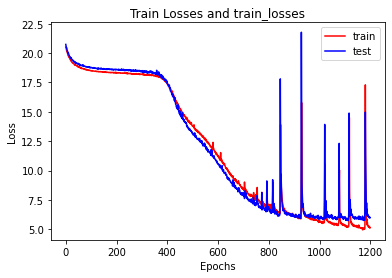

In [11]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg, 'r')
plt.plot(test_losses, 'b')
plt.legend(["train", "test"])
plt.title("Train Losses and train_losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [12]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [13]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

Sampling

In [14]:
S = X_test.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = decoder(z)

In [15]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

In [16]:
x_samples.mean(0)

tensor([-0.2783, -0.1541, -0.1763,  0.2208, -0.0384, -0.0024, -0.0382,  0.0659,
        -0.1182, -0.0436,  0.0433,  0.1083, -0.0407], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [17]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [18]:
x_samples.std(0)

tensor([1.4670, 5.2668, 1.1180, 5.6085, 0.8531, 0.3820, 0.7310, 1.0322, 0.9477,
        0.9958, 0.4653, 1.4167, 0.6540], dtype=torch.float64,
       grad_fn=<StdBackward1>)

In [19]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

Text(0, 0.5, 'Mean of Generated Distribution')

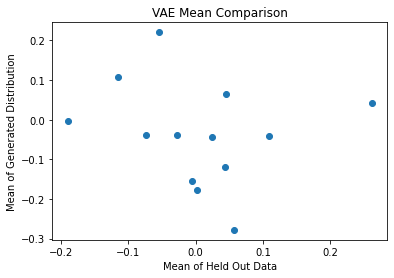

In [20]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

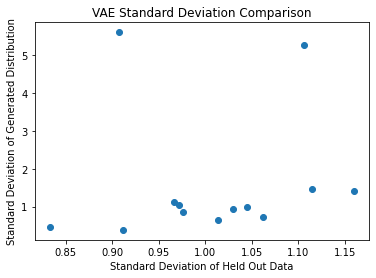

In [21]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

In [22]:
# figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
# for i in range(x_samples.shape[1]):
#     axs[i].scatter([x_test[:,i], x_samples[:,i]], color=['red','green'])
#     axs[i].legend(["data", "sample"])
# plt.show()

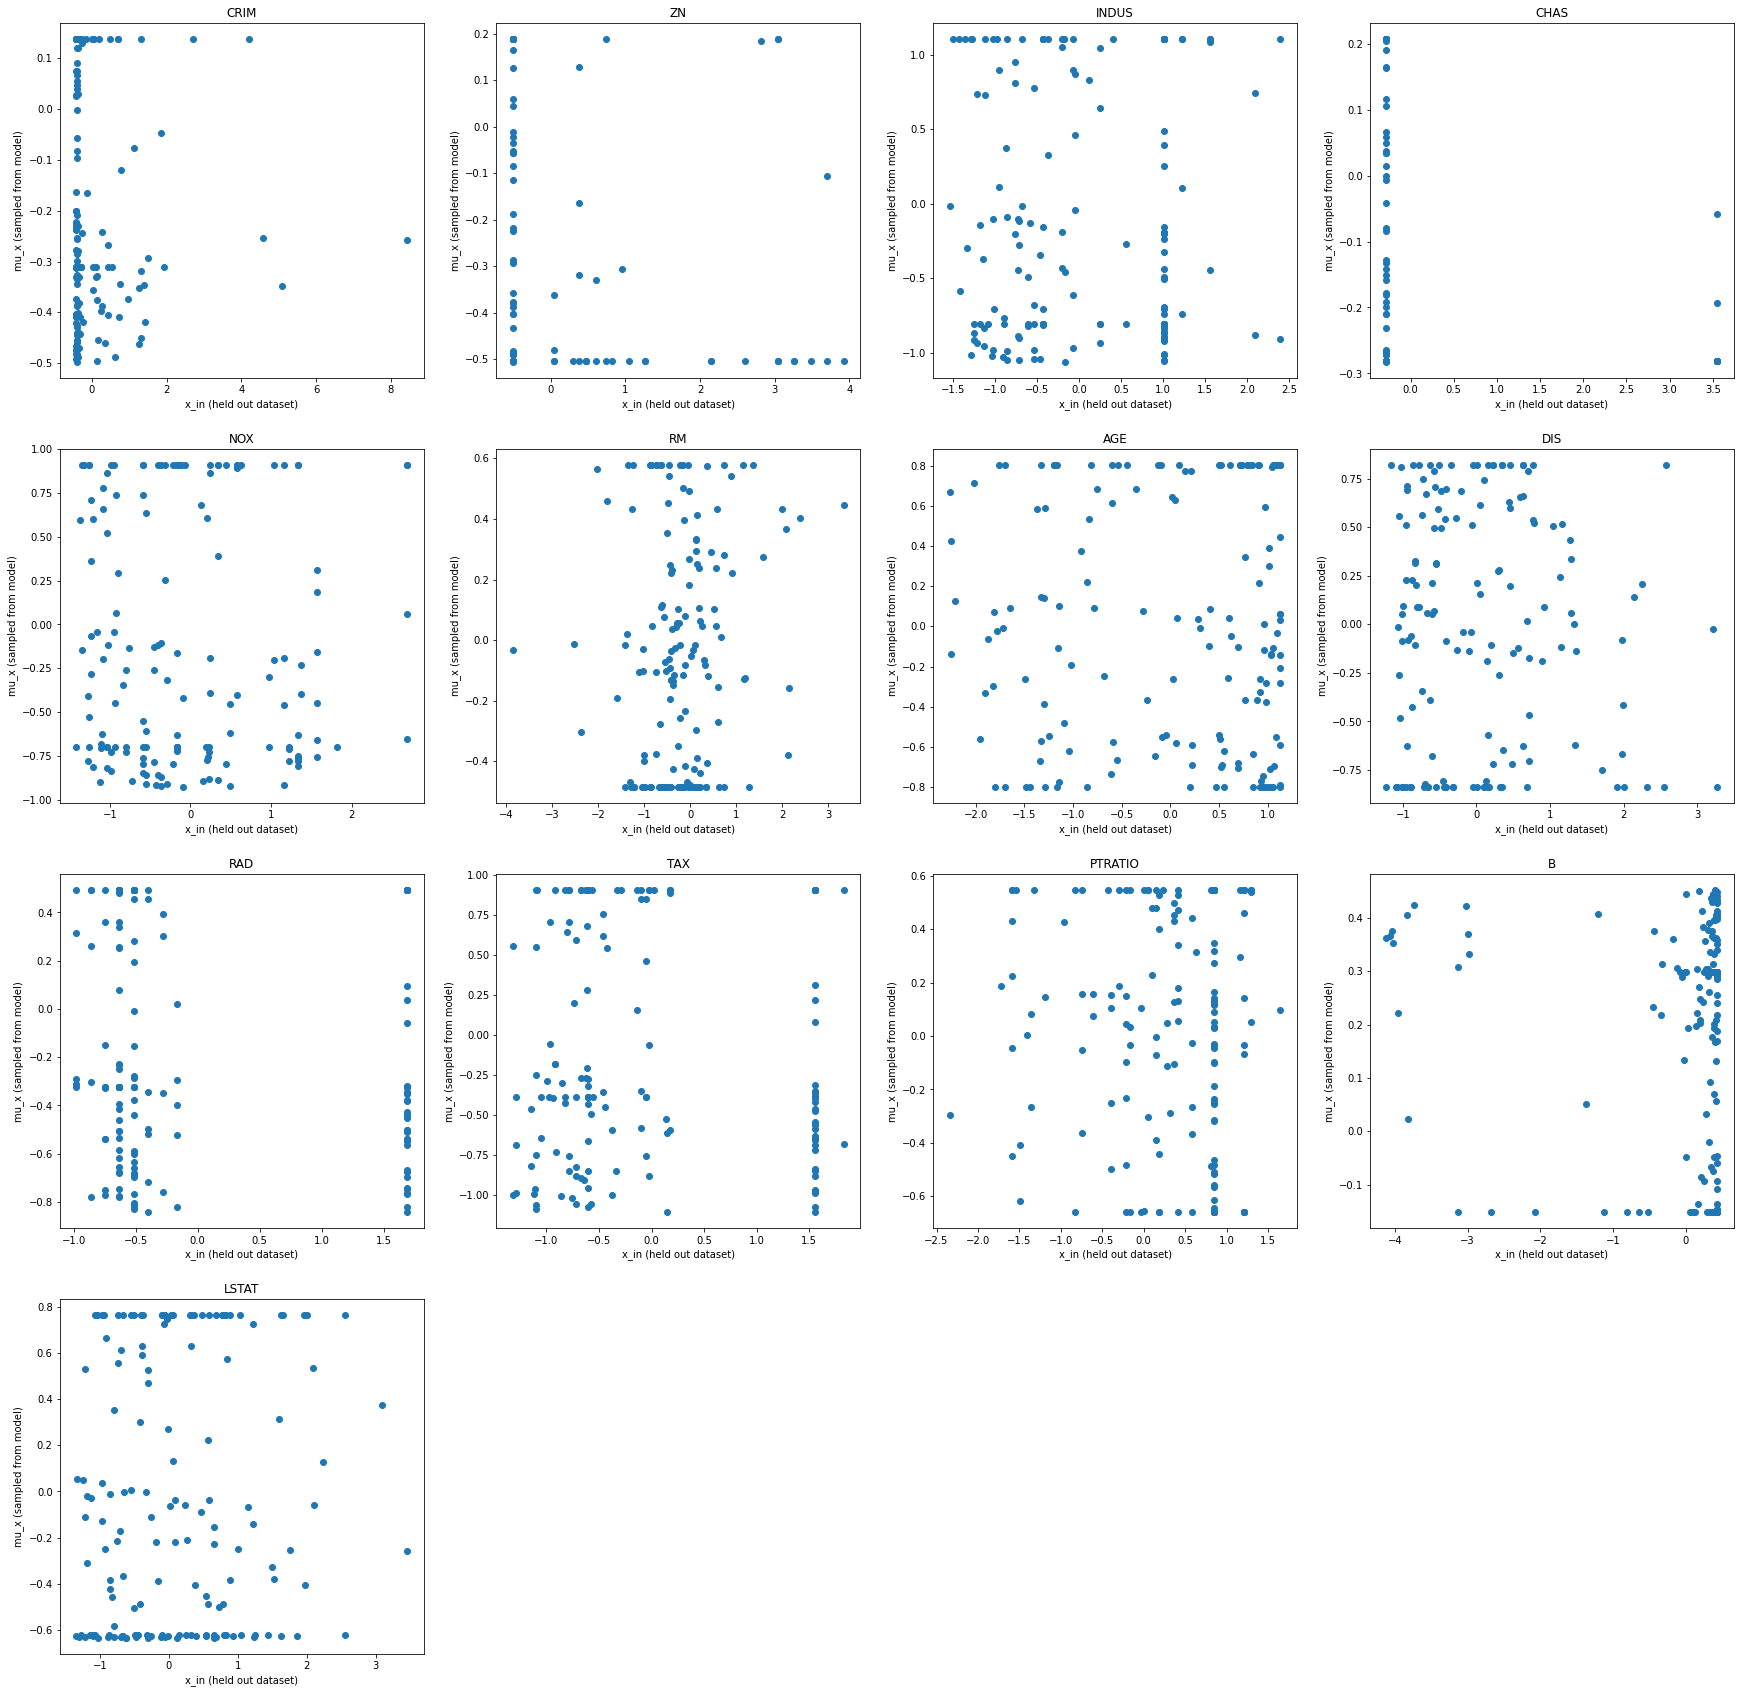

In [23]:
x_test = X_test.detach().numpy()
mu_x = mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(x_test[:,i*4+j], mu_x[:,i*4+j])
        axs[i, j].set_title(bos.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (sampled from model)")
        axs[i, j].set_xlabel("x_in (held out dataset)")
    if i*4+j >= 13: 
        break 

plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [24]:
X_test.shape

torch.Size([152, 13])

In [25]:
x_samples.shape

torch.Size([152, 13])

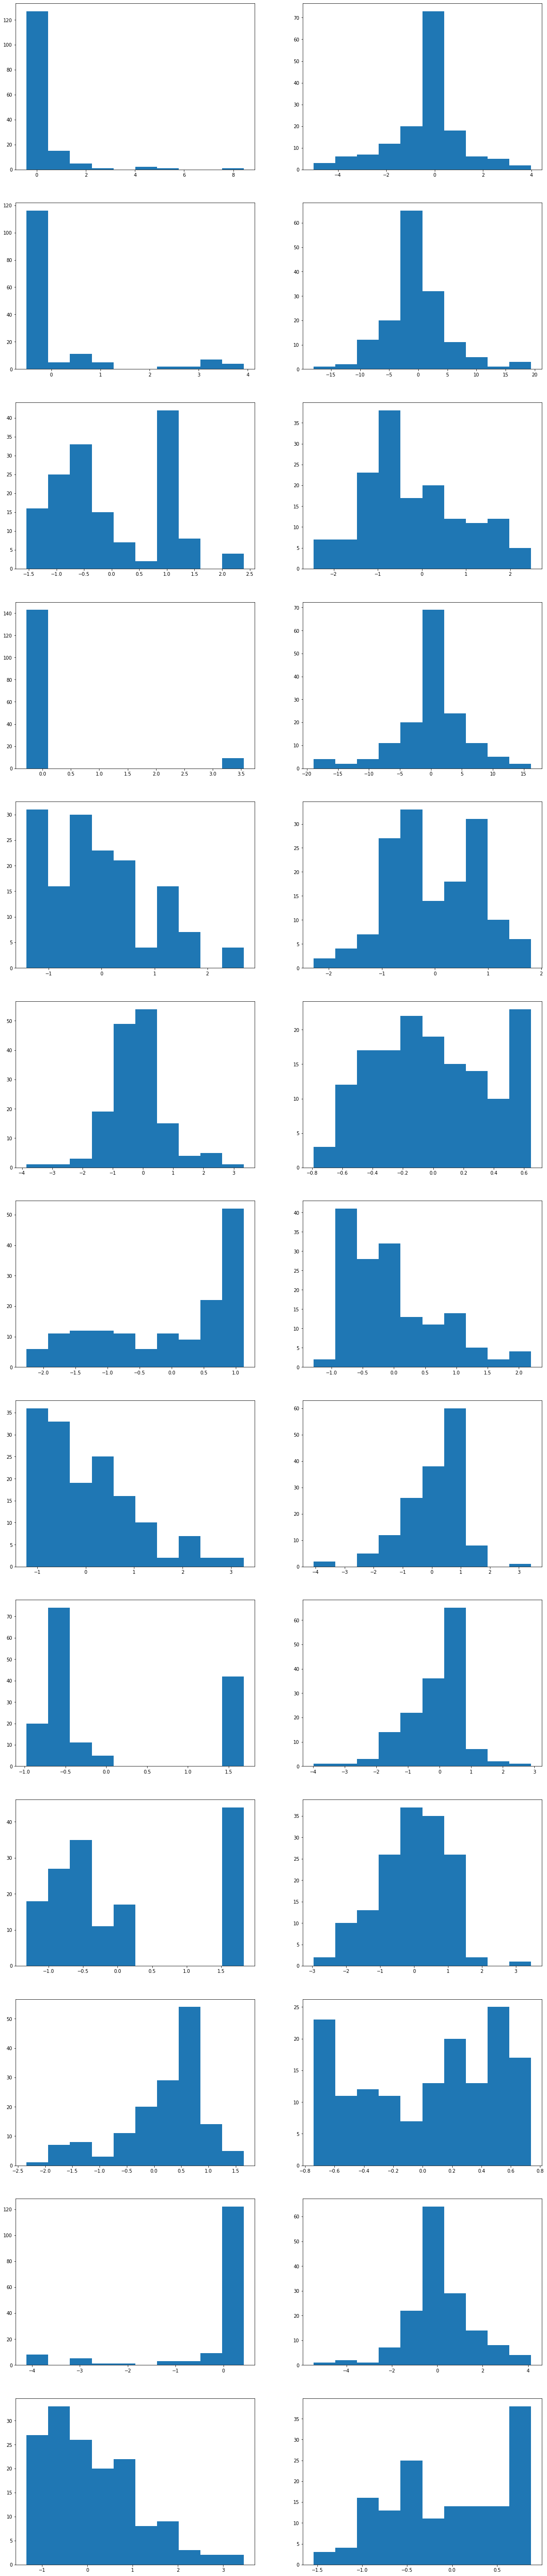

In [26]:
x_samples = x_samples.detach().numpy()
figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
for i in range(x_samples.shape[1]):
    axs[i, 0].hist(x_test[:,i])
    axs[i, 1].hist(x_samples[:,i])
plt.show()

In [27]:
x_samples.mean(0)

array([-0.27825233, -0.15407858, -0.17629155,  0.22080344, -0.03844213,
       -0.00244556, -0.03819193,  0.06585711, -0.11822382, -0.04355962,
        0.04334484,  0.10831492, -0.04067077])

In [28]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [29]:
x_samples.std(0)

array([1.4621988 , 5.24944989, 1.11429094, 5.5900416 , 0.85032217,
       0.38070543, 0.72859409, 1.02883614, 0.94457414, 0.99250424,
       0.46373673, 1.41206975, 0.6518343 ])

In [30]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

1. What are the 13 features 
2. What does plotting the histogram represent. 

In [31]:
np.corrcoef(X_test, rowvar=False)[0]

array([ 1.        , -0.1910687 ,  0.42486438, -0.08718963,  0.46821577,
       -0.23795259,  0.38613771, -0.40293044,  0.63190985,  0.58463217,
        0.27942462, -0.52906495,  0.55059428])

In [32]:
np.corrcoef(x_samples, rowvar=False)[0]

array([ 1.        ,  0.03360863,  0.12834335,  0.050239  ,  0.16702811,
       -0.23712331,  0.1451665 , -0.17882315, -0.09661041,  0.15473691,
        0.17262094,  0.26265788,  0.20029392])

In [33]:
np.corrcoef(X_test, rowvar=False)[1]

array([-0.1910687 ,  1.        , -0.51290453, -0.06876205, -0.49604812,
        0.34901083, -0.54269001,  0.65072851, -0.29812013, -0.33169892,
       -0.45453415,  0.18209134, -0.45634992])

In [34]:
np.corrcoef(x_samples, rowvar=False)[1]

array([ 3.36086287e-02,  1.00000000e+00, -4.11318009e-02, -5.94319000e-02,
       -5.30247367e-02, -2.68975293e-02, -3.72973868e-02,  1.67773541e-01,
       -4.16816601e-02, -2.14231374e-02, -3.81981919e-02, -3.05711914e-02,
       -9.37848543e-04])

In [35]:
np.corrcoef(X_test, rowvar=False)[2]

array([ 0.42486438, -0.51290453,  1.        ,  0.03220062,  0.76409769,
       -0.35575224,  0.66757595, -0.72731343,  0.63361793,  0.7646962 ,
        0.45750608, -0.41160893,  0.66605524])

In [36]:
np.corrcoef(x_samples, rowvar=False)[2]

array([ 0.12834335, -0.0411318 ,  1.        , -0.01540504,  0.53894078,
       -0.69075734,  0.57767609, -0.38120904,  0.28249848,  0.49612475,
        0.64043481, -0.11129558,  0.67971565])

In [37]:
np.corrcoef(X_test, rowvar=False)[3]

array([-0.08718963, -0.06876205,  0.03220062,  1.        ,  0.06471079,
       -0.05183806,  0.09452797, -0.06774048, -0.14252854, -0.15269275,
       -0.21787821, -0.00468345,  0.07728061])

In [38]:
np.corrcoef(x_samples, rowvar=False)[3]

array([ 0.050239  , -0.0594319 , -0.01540504,  1.        ,  0.04996589,
       -0.02940641, -0.16673889, -0.02584914, -0.01005051,  0.05847839,
       -0.03452594,  0.0221431 , -0.03021334])